In [99]:
import pandas as pd 
import pandas.io.sql as psql

In [56]:
import numpy as np

In [57]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [58]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [59]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect 

In [60]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)


In [61]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [64]:
# We can view all of the classes that automap found
keys = Base.classes.keys()
print(keys)
print(inspector.get_table_names())

['measurement', 'station']
['measurement', 'station']


In [63]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='Temperature "F"', ylabel='Precipitation'>

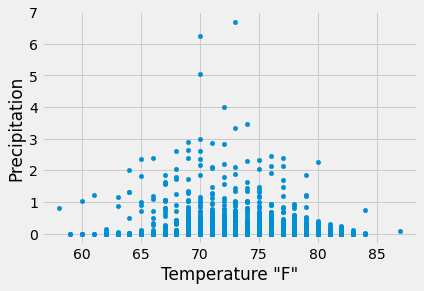

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdate = session \
    .query(measurements, func.max(measurements.date)).\
    order_by(measurements.date.desc()).all()
# Max Date showed: [(<sqlalchemy.ext.automap.measurement object at 0x0000025AB00C72B0>, '2017-08-23')]
# Perform a query to retrieve the data and precipitation scores
date = dt.datetime(2016, 8, 23)
m_results = session.query(measurements.tobs, measurements.prcp, 
                        measurements.date).\
                  filter(measurements.date > date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(m_results, columns = ['Temperature "F"', 'Precipitation', 'Date'])
# Sort the dataframe by date
measurement_df.sort_values(by='Date', ascending=False)
measurement_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot.scatter(y='Precipitation',
                      x='Temperature "F"')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = measurement_df[['Precipitation']].describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(measurements.station).\
                  filter(measurements.date > date).count()
print(station_count)

2223


In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measurement_df["station"] = session.query(measurements.station).\
                  filter(measurements.date > date).all()
measurement_df["station"] = measurement_df["station"].astype(str).str.replace(r'\(|\)|,|''', '')
station_groupby = measurement_df.groupby(["station"]).mean()
station_groupby["count"] = session.query(measurements.station).\
                  filter(measurements.date > date, measurements.station == measurements.station).group_by(measurements.station).\
                    order_by(measurements.station.desc()).count()
#stat_counter = str(station_count[1])
#station_groupby["count"] =  stat_counter
print(station_groupby.head())

               Temperature "F"  Precipitation  count
station                                             
'USC00513117'        73.269006       0.141404      7
'USC00514830'        77.151316       0.125720      7
'USC00516128'        72.086207       0.449878      7
'USC00517948'        74.752747       0.076500      7
'USC00519281'        73.096866       0.194416      7


In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station = "USC00513117"
station_stats_min_temp =  session.query(measurements, func.min(measurements.tobs)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
min_temp = station_stats_min_temp[1]
station_stats_max_temp = session.query(measurements, func.max(measurements.tobs)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
max_temp = station_stats_max_temp[1]
station_stats_mean_temp = session.query(measurements, func.avg(measurements.tobs)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
mean_temp = station_stats_mean_temp[1]
station_stats_min_prec =  session.query(measurements, func.min(measurements.prcp)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
min_prec = station_stats_min_prec[1]
station_stats_max_prec = session.query(measurements, func.max(measurements.prcp)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
max_prec = station_stats_max_prec[1]
station_stats_mean_prec = session.query(measurements, func.avg(measurements.prcp)).\
                  filter(measurements.station == station).\
                    order_by(measurements.tobs.asc()).first()
mean_prec = station_stats_mean_prec[1]
station_count_df = pd.DataFrame({"lowest": [min_temp, min_prec],
                                "highest": [max_temp, max_prec],
                                "average": [mean_temp, mean_prec],},
                               index = ["Temperature", "Precipitation"])
station_count_df.head()

,lowest,highest,average
Temperature,59.0,85.00,72.689184
Precipitation,0.0,7.65,0.141921


<AxesSubplot:title={'center':'Range of High Temperature'}, ylabel='Frequency'>

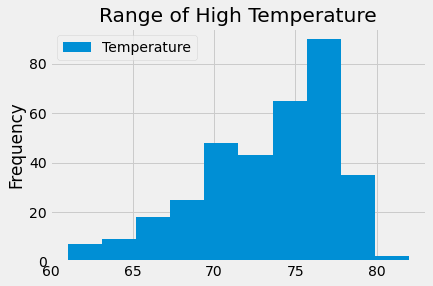

In [118]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date = dt.datetime(2016, 8, 23)
station_results = session.query(measurements.tobs, 
                        measurements.date).\
                  filter(measurements.date > date, measurements.station == station).all()

station_result_df = pd.DataFrame(station_results, columns=['Temperature','Date'])

station_result_df.plot.hist(x='Date', y='Temperature', ylabel='temperature',  title = "Range of High Temperature")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [124]:
session.close()